In [204]:
import numpy as np
import pandas as pd
import h5py
import pyute as ut
from importlib import reload
reload(ut)
import pdb
import matplotlib.pyplot as plt
import utils
reload(utils)
import sklearn
import scipy.stats as sst
import sklearn.cluster as skc
import os
import shutil
import sklearn.metrics as skm
%matplotlib notebook

In [2]:
dsbase = '/home/mossing/Documents/notebooks/shared_data/'
ttls = ['pyr_l4','pyr_l23','sst_l23','vip_l23','pv_l23']
namelist = [ttl+'_data_struct.hdf5' for ttl in ttls]
dsnames = [dsbase+x for x in namelist]

In [3]:
reload(ut)
df = pd.DataFrame()
roi_info,trial_info = [{},{}]
for dsname,ttl in zip(dsnames,ttls):
    this_df, this_roi_info, this_trial_info = ut.compute_tavg_dataframe(dsname,'size_contrast_0',datafield='decon')
    for x in [this_df]:
        x['celltype'] = ttl
    for x in [this_roi_info,this_trial_info]:
        for key in x.keys():
            x[key]['celltype'] = ttl
    df = df.append(this_df)
    roi_info.update(this_roi_info)
    trial_info.update(this_trial_info)

<HDF5 group "/session_181127_M10073" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_190202_M10075" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_190304_M10077" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_190607_M10443" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_190620_M10616" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_190620_M10619" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/se

In [114]:
df_small = df.loc[df.session_id=='session_191105_M0589']

In [149]:
ontarget = (roi_info['session_191105_M0589']['rf_displacement']**2).sum(0)<5**2

In [143]:
tuning[on_target].shape

(46, 39)

In [115]:
selector = utils.gen_selector_running(run=False)

In [116]:
reload(utils)
tuning = utils.compute_tuning_df(df_small,trial_info,selector)

In [178]:
plt.close('all')

In [243]:
def compute_auroc(a1,a2):
    vals = np.concatenate((a1,a2))
    grps = np.concatenate((np.zeros_like(a1),np.ones_like(a2)))
    vals_argsort = np.argsort(-vals)
    fp,tp = [np.cumsum(grps[vals_argsort]==thing)/np.sum(grps[vals_argsort]==thing) for thing in (0,1)]
    return skm.auc(fp,tp)

In [254]:
this_expt = 'session_181127_M10073'
this_df = df.loc[df.session_id==this_expt]
nroi = len(np.unique(this_df.roi_index))
ucontrast = np.unique(trial_info[this_expt]['stimulus_contrast'])
ncontrast = len(ucontrast)
usize = np.unique(trial_info[this_expt]['stimulus_size_deg'])
nsize = len(usize)
auroc = np.zeros((nroi,ncontrast-1))
for icontrast in range(len(ucontrast)-1):
    print(ucontrast[icontrast+1])
    for iroi in range(len(auroc)):
    #     print(iroi)
        this_roi = this_df.loc[this_df.roi_index==iroi]
        zero_contrast = trial_info[this_expt]['stimulus_contrast']==0
        df0 = this_roi.loc[zero_contrast[this_roi.trial_index]]
        low_contrast = np.logical_and(trial_info[this_expt]['stimulus_contrast']==ucontrast[icontrast+1],trial_info[this_expt]['stimulus_size_deg']==usize[0])
        df1 = this_roi.loc[low_contrast[this_roi.trial_index]]

        # df0s = np.sort(df0.data)
        # df1s = np.sort(df1.data)
        # plt.plot(df0s)
        # plt.plot(df1s)
        vals = np.concatenate((df0.data,df1.data))
        grps = np.concatenate((np.zeros_like(df0.data),np.ones_like(df1.data)))
        vals_argsort = np.argsort(-vals)

        fp,tp = [np.cumsum(grps[vals_argsort]==thing)/np.sum(grps[vals_argsort]==thing) for thing in (0,1)]
        # plt.plot(fp,tp)
        auroc[iroi,icontrast] = skm.auc(fp,tp)

# plt.figure()
# plt.hist(df0.data,alpha=0.5)
# plt.hist(df1.data,alpha=0.5)

0.03
0.06
0.12
0.25
0.5
1.0


<IPython.core.display.Javascript object>


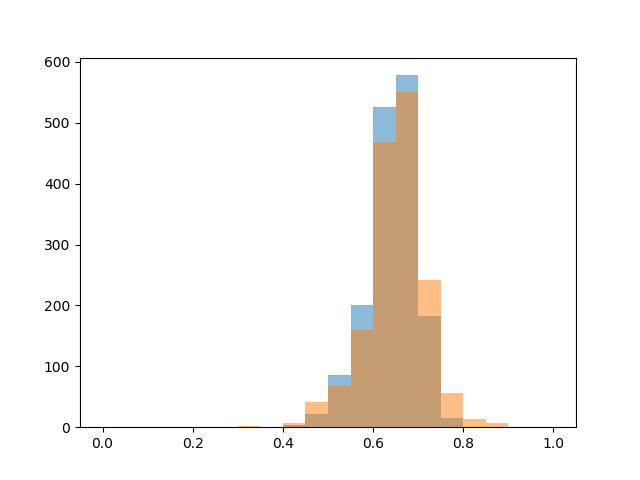

(array([  0.,   0.,   0.,   0.,   0.,   1.,   2.,   1.,   7.,  41.,  67.,
        160., 469., 550., 241.,  56.,  13.,   7.,   0.,   0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

In [257]:
plt.figure()
plt.hist(auroc[:,0],alpha=0.5,bins=np.linspace(0,1,21))
plt.hist(auroc[:,1],alpha=0.5,bins=np.linspace(0,1,21))

<IPython.core.display.Javascript object>


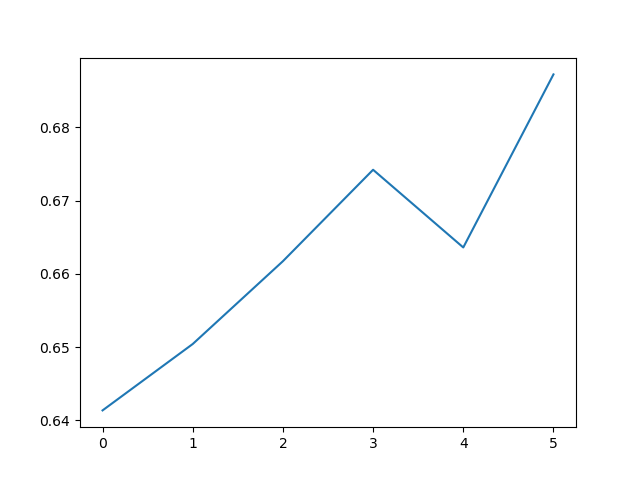

In [258]:
plt.figure()
plt.plot(auroc.mean(0))

In [215]:
# plt.figure()
# df0s = np.sort(df0.data)
# df1s = np.sort(df1.data)
# plt.plot(df0s)
# plt.plot(df1s)
# vals = np.concatenate((df0s,df1s))
# grps = np.concatenate((np.zeros_like(df0s),np.ones_like(df1s)))
# vals_argsort = np.argsort(-vals)

In [216]:
# plt.figure()
# fp,tp = [np.cumsum(grps[vals_argsort]==thing)/np.sum(grps[vals_argsort]==thing) for thing in (0,1)]
# plt.plot(fp,tp)
# skm.auc(fp,tp)

In [117]:
reload(utils)
npartitionings = 5
tunings = utils.compute_tuning_many_partitionings(df,trial_info,npartitionings)

KeyboardInterrupt: 

In [36]:
with ut.hdf5read(dsnames[0]) as ds:
    keylist = list(ds.keys())
    print(ds[keylist[0]]['size_contrast_0'].keys())

<KeysViewHDF5 ['F', 'decon', 'nafter', 'nbefore', 'neuropil_trialwise', 'pupil_area_trialwise_pix', 'pupil_ctr_trialwise_pix', 'raw_trialwise', 'rf_ctr', 'rf_displacement_deg', 'rf_distance_deg', 'rf_mapping_pval', 'running_speed_cm_s', 'stim_offset_deg', 'stimulus_contrast', 'stimulus_direction_deg', 'stimulus_id', 'stimulus_parameters', 'stimulus_size_deg', 't_offset']>


<IPython.core.display.Javascript object>


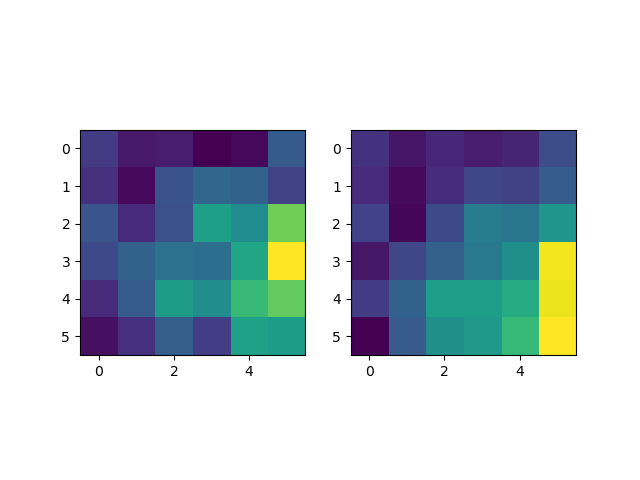

In [150]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.array(tuning.loc[ontarget].iloc[:,:36].mean(0)).reshape((6,6)))
plt.subplot(1,2,2)
plt.imshow(np.array(tuning.loc[~ontarget].iloc[:,:36].mean(0)).reshape((6,6)))

<IPython.core.display.Javascript object>


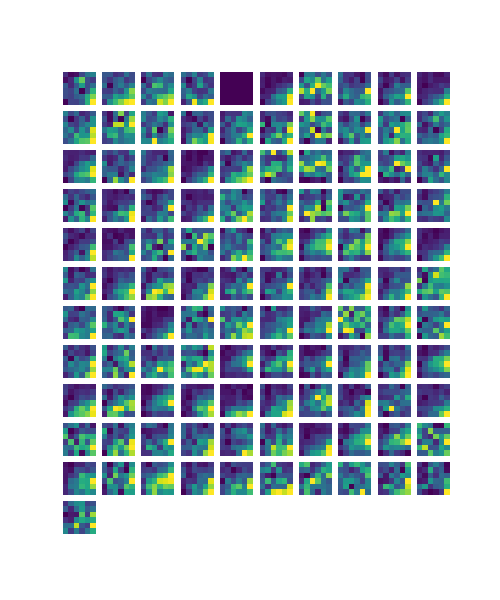

In [134]:
ut.imshow_in_rows(np.array(tuning.iloc[:200,:36]).reshape((-1,6,6)))

In [88]:
np.nanmax(tunings.iloc[:,0])

2.05035999417305

In [107]:
tunings['partitioning','']

0      0
1      0
2      0
3      0
4      0
      ..
253    4
254    4
255    4
256    4
257    4
Name: (partitioning, ), Length: 295240, dtype: int64

In [109]:
session_ids = np.unique(tunings['session_id',''])
areas = np.unique(tunings['celltype',''])

In [110]:
def compute_r2(x,y):
    return 1-0.5*np.var(x-y,1)*(1/np.var(x,1) + 1/np.var(y,1))

In [111]:
areas

array(['pv_l23', 'pyr_l23', 'pyr_l4', 'sst_l23', 'vip_l23'], dtype=object)

In [ ]:
# generate a set of indices s.t. one can use the same "utils.nubs_active" variable
# for each. This will be a conversion s.t. new trial_info nubs = transl[trial_info nubs]

In [ ]:
keylist = list(roi_info.keys())

In [ ]:
def by_prefix(area,prefix):
    return [x[:2] ==prefix for x in df.area]

In [ ]:
def gen_Xs_ys(df,trial_type,exptname,train_test,neuron_subset=None,stim_subset=None):
    in_this_expt = (df.session_id==exptname)
    df_expt = df.loc[in_this_expt]
    df_part = [df_expt.loc[train_test[p][df_expt.trial_index]] for p in range(2)]
    pivoted = [dfp.pivot('trial_index','roi_index','data') for dfp in df_part]
    ys = [trial_type[piv.index] for piv in pivoted]
    if neuron_subset is None:
        Xs = [np.array(piv) for piv in pivoted]
    else:
        Xs = [np.array(piv)[:,neuron_subset] for piv in pivoted]
    if not stim_subset is None:
        trials_to_keep = [np.in1d(yy,stim_subset) for yy in ys]
        ys = [yy[ttk] for yy,ttk in zip(ys,trials_to_keep)]
        Xs = [xx[ttk] for xx,ttk in zip(Xs,trials_to_keep)]
    return Xs,ys

In [ ]:
for iexpt in range(len(keylist)):
    nroi = roi_info[keylist[iexpt]]['cell_center'].shape[1]
    print(nroi)

In [221]:
def log_predict_and_score(Xs,ys):
    logreg = sklearn.linear_model.LogisticRegression(multi_class='auto',solver='liblinear',penalty='l2').fit(Xs[0],ys[0])        
    score = logreg.score(Xs[1],ys[1])
    return logreg,score

In [41]:
# plt.figure()
# plt.imshow(predict_shape[np.argsort(sna)],extent=[0,1,0,1])

In [214]:
r2 = [None for iexpt in range(len(keylist))]
for iexpt in range(len(r2)):
    for q in range(npartitionings):
        xs = [np.array(tunings.loc[ut.k_and(tunings.session_id==keylist[iexpt],tunings.partition==p,tunings.partitioning==q)].iloc[:,:32]) for p in range(2)]
        if q==0:
            nroi = xs[0].shape[0]
            r2[iexpt] = np.zeros((npartitionings,nroi))
        r2[iexpt][q] = compute_r2(*xs)
    r2[iexpt] = r2[iexpt].mean(0)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [215]:
bins = np.linspace(-3,1,10)
Hr2 = np.zeros((len(r2),len(bins)-1),dtype='int')
binno = [None for iexpt in range(len(r2))]
for iexpt in range(len(r2)):
    Hr2[iexpt],_ = np.histogram(r2[iexpt],bins=bins)
    binno[iexpt] = np.digitize(r2[iexpt],bins=bins)
hist_target = np.min(Hr2[:10],axis=0)
# alpha = 0.25
# plt.figure()
# plt.subplot(1,2,1)
# for iexpt in range(6):
#     plt.hist(r2[iexpt],bins=bins,alpha=alpha)
# #     plt.xlim(-1,1)
# plt.subplot(1,2,2)
# for iexpt in range(6,10):
#     plt.hist(r2[iexpt],bins=bins,alpha=alpha)
# #     plt.xlim(-1,1)